# Feature Engineering for Drug-Disease Interaction Prediction

This notebook demonstrates the feature engineering process for our drug-disease interaction prediction model. We'll extract and preprocess features for different node types in the knowledge graph and prepare training data for the model.

## Setup

First, let's import the necessary libraries and load the knowledge graph.

In [1]:
import os
import sys
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from typing import Dict, List, Tuple, Any, Optional, Set

# Ensure we can import from src
sys.path.append(str(Path.cwd().parent))

# Import our modules
from src.ddi.features.feature_engineering import FeatureExtractor
from src.ddi.analysis.graph_analysis import GraphAnalyzer
from src.ddi.visualization.graph_viz import GraphVisualizer

# Set up plotting defaults
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
%matplotlib inline

### Load the Knowledge Graph

We'll load the knowledge graph that we built in the previous steps.

In [2]:
# Path to the saved graph file
graph_path = "../data/graph/full/knowledge_graph.pickle"

# Load the graph
with open(graph_path, "rb") as f:
    graph = pickle.load(f)

print(f"Loaded knowledge graph with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")

# Create feature extractor, analyzer, and visualizer
extractor = FeatureExtractor(graph)
analyzer = GraphAnalyzer(graph)
visualizer = GraphVisualizer(output_dir="../figures")

Loaded knowledge graph with 17430 nodes and 0 edges


## 1. Exploring Node Types

Let's first explore the different types of nodes in our knowledge graph to understand what features we need to extract.

Node types in the knowledge graph:


,Node Type,Count
0,drug,17430


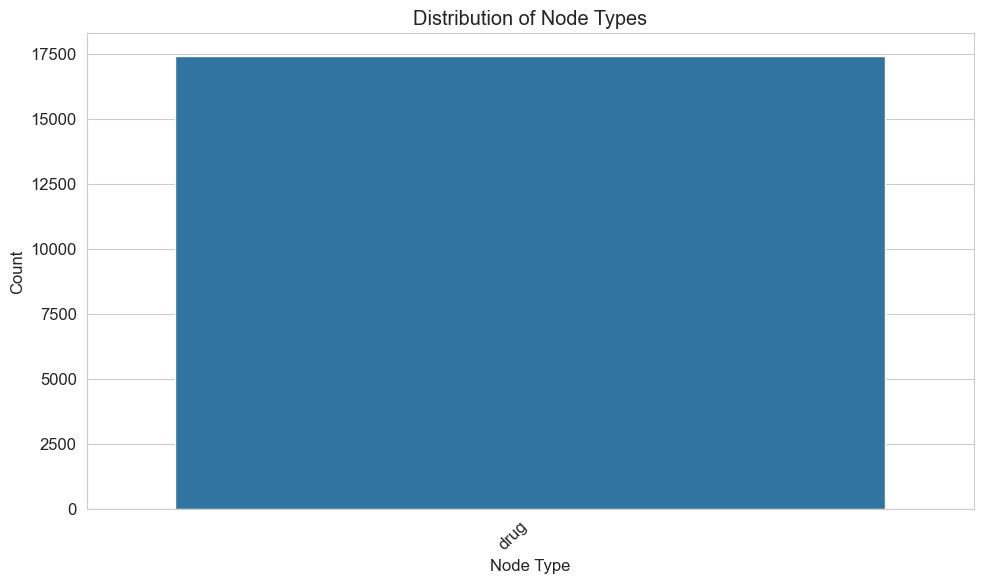

In [3]:
# Count node types
node_types = {}
for node, data in graph.nodes(data=True):
    node_type = data.get("type", "unknown")
    if node_type not in node_types:
        node_types[node_type] = 0
    node_types[node_type] += 1

# Display node type counts
node_type_df = pd.DataFrame({
    "Node Type": list(node_types.keys()),
    "Count": list(node_types.values())
}).sort_values("Count", ascending=False).reset_index(drop=True)

print("Node types in the knowledge graph:")
display(node_type_df)

# Visualize node type distribution
plt.figure(figsize=(10, 6))
sns.barplot(x="Node Type", y="Count", data=node_type_df)
plt.title("Distribution of Node Types")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Let's examine the attributes available for each node type to see what features we can extract.

In [4]:
# Function to analyze node attributes for a given type
def analyze_node_attributes(graph, node_type, max_examples=5):
    # Get nodes of this type
    nodes = [n for n, d in graph.nodes(data=True) if d.get("type") == node_type]
    if not nodes:
        return f"No nodes of type '{node_type}' found."
    
    # Sample nodes
    sample_nodes = np.random.choice(nodes, size=min(max_examples, len(nodes)), replace=False)
    
    # Collect all attributes
    all_attrs = set()
    for node in sample_nodes:
        all_attrs.update(graph.nodes[node].keys())
    
    # Count attribute prevalence
    attr_counts = {attr: 0 for attr in all_attrs}
    for node in nodes:
        for attr in all_attrs:
            if attr in graph.nodes[node]:
                attr_counts[attr] += 1
    
    # Calculate percentages
    attr_percentages = {attr: (count / len(nodes)) * 100 for attr, count in attr_counts.items()}
    
    # Create result DataFrame
    result_df = pd.DataFrame({
        "Attribute": list(attr_counts.keys()),
        "Count": list(attr_counts.values()),
        "Percentage": [f"{attr_percentages[attr]:.1f}%" for attr in attr_counts.keys()]
    }).sort_values("Count", ascending=False).reset_index(drop=True)
    
    # Show examples for each attribute
    examples = {}
    for attr in all_attrs:
        attr_examples = []
        for node in sample_nodes:
            if attr in graph.nodes[node]:
                value = graph.nodes[node][attr]
                # Truncate long values
                if isinstance(value, str) and len(value) > 50:
                    value = value[:50] + "..."
                # Handle list values
                elif isinstance(value, list) and len(value) > 3:
                    value = value[:3] + ["..."]
                attr_examples.append(str(value))
        examples[attr] = ", ".join(attr_examples) if attr_examples else "N/A"
    
    examples_df = pd.DataFrame({
        "Attribute": list(examples.keys()),
        "Examples": list(examples.values())
    }).sort_values("Attribute").reset_index(drop=True)
    
    return result_df, examples_df

In [5]:
# Analyze attributes for each key node type
key_node_types = ["drug", "disease", "protein", "polypeptide"]

for node_type in key_node_types:
    print(f"\n{node_type.upper()} NODE ATTRIBUTES:")
    result = analyze_node_attributes(graph, node_type)
    
    if isinstance(result, tuple):
        counts_df, examples_df = result
        print(f"Attribute prevalence:")
        display(counts_df)
        print(f"Example values:")
        display(examples_df)
    else:
        print(result)


DRUG NODE ATTRIBUTES:
Attribute prevalence:


,Attribute,Count,Percentage
0,name,17430,100.0%
1,type,17430,100.0%


Example values:


,Attribute,Examples
0,name,"Black widow spider antivenin (equine), Technet..."
1,type,"drug, drug, drug, drug, drug"



DISEASE NODE ATTRIBUTES:
No nodes of type 'disease' found.

PROTEIN NODE ATTRIBUTES:
No nodes of type 'protein' found.

POLYPEPTIDE NODE ATTRIBUTES:
No nodes of type 'polypeptide' found.


## 2. Feature Engineering for Drug Nodes

Let's extract features for drug nodes, which will include:

1. Network features (degree, centrality, etc.)
2. Molecular features (properties from DrugBank)
3. Categorical features (groups, categories, ATC codes)

In [6]:
# Get all drug nodes
drug_nodes = [n for n, d in graph.nodes(data=True) if d.get("type") == "drug"]
print(f"Extracting features for {len(drug_nodes)} drug nodes")

# Extract drug features
drug_features = extractor.extract_drug_features(drug_nodes)

# Show available feature types
print("\nAvailable feature types:")
for feature_type, feature_array in drug_features.items():
    if feature_type != "node_id":
        print(f"  - {feature_type}: {feature_array.shape}")

Extracting features for 17430 drug nodes


KeyboardInterrupt: 

In [ ]:
# Create a DataFrame with node IDs and names
drug_names = [graph.nodes[node].get("name", node) for node in drug_features["node_id"]]
drug_df = pd.DataFrame({"node_id": drug_features["node_id"], "name": drug_names})

# Add network features
network_columns = [f"network_{i}" for i in range(drug_features["network_features"].shape[1])]
network_df = pd.DataFrame(drug_features["network_features"], columns=network_columns)
drug_df = pd.concat([drug_df, network_df], axis=1)

# Display a sample of the data
print("Sample of drug features:")
display(drug_df.head())

# Calculate feature correlations
plt.figure(figsize=(10, 8))
corr = network_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix of Drug Network Features")
plt.tight_layout()
plt.show()

In [ ]:
# Visualize drug embeddings using PCA
if "embedding_features" in drug_features:
    # Apply PCA to reduce to 2D
    pca = PCA(n_components=2)
    drug_pca = pca.fit_transform(drug_features["embedding_features"])
    
    # Create DataFrame for plotting
    pca_df = pd.DataFrame({
        "PCA1": drug_pca[:, 0],
        "PCA2": drug_pca[:, 1],
        "Drug": drug_names
    })
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x="PCA1", y="PCA2", data=pca_df, alpha=0.7)
    
    # Add labels for some points
    n_labels = 20
    for i in range(min(n_labels, len(pca_df))):
        plt.text(pca_df.iloc[i]["PCA1"], pca_df.iloc[i]["PCA2"], pca_df.iloc[i]["Drug"],
                fontsize=8, ha="center", va="center")
    
    plt.title(f"PCA of Drug Embeddings (explained variance: {pca.explained_variance_ratio_.sum():.2f})")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 3. Feature Engineering for Disease Nodes

Now let's extract features for disease nodes, which will include:

1. Network features (degree, centrality, etc.)
2. Tree features (hierarchy information from MeSH)
3. Categorical features (top-level categories)

In [ ]:
# Get all disease nodes
disease_nodes = [n for n, d in graph.nodes(data=True) if d.get("type") == "disease"]
print(f"Extracting features for {len(disease_nodes)} disease nodes")

# Extract disease features
disease_features = extractor.extract_disease_features(disease_nodes)

# Show available feature types
print("\nAvailable feature types:")
for feature_type, feature_array in disease_features.items():
    if feature_type != "node_id":
        print(f"  - {feature_type}: {feature_array.shape}")

In [ ]:
# Create a DataFrame with node IDs and names
disease_names = [graph.nodes[node].get("name", node) for node in disease_features["node_id"]]
disease_df = pd.DataFrame({"node_id": disease_features["node_id"], "name": disease_names})

# Add tree features
tree_columns = [f"tree_{i}" for i in range(disease_features["tree_features"].shape[1])]
tree_df = pd.DataFrame(disease_features["tree_features"], columns=tree_columns)
disease_df = pd.concat([disease_df, tree_df], axis=1)

# Display a sample of the data
print("Sample of disease features:")
display(disease_df.head())

# Calculate feature correlations
plt.figure(figsize=(10, 8))
corr = tree_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix of Disease Tree Features")
plt.tight_layout()
plt.show()

In [ ]:
# Visualize disease embeddings using t-SNE
if "embedding_features" in disease_features:
    # Apply t-SNE to reduce to 2D
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    disease_tsne = tsne.fit_transform(disease_features["embedding_features"])
    
    # Create DataFrame for plotting
    tsne_df = pd.DataFrame({
        "TSNE1": disease_tsne[:, 0],
        "TSNE2": disease_tsne[:, 1],
        "Disease": disease_names
    })
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x="TSNE1", y="TSNE2", data=tsne_df, alpha=0.7)
    
    # Add labels for some points
    n_labels = 20
    for i in range(min(n_labels, len(tsne_df))):
        plt.text(tsne_df.iloc[i]["TSNE1"], tsne_df.iloc[i]["TSNE2"], tsne_df.iloc[i]["Disease"],
                fontsize=8, ha="center", va="center")
    
    plt.title("t-SNE of Disease Embeddings")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. Feature Engineering for Protein/Polypeptide Nodes

Let's extract features for protein and polypeptide nodes, which will include:

1. Network features (degree, centrality, etc.)
2. Sequence features (amino acid composition)
3. Categorical features (organism, cellular location, GO terms)

In [ ]:
# Get all protein nodes
protein_nodes = [n for n, d in graph.nodes(data=True) if d.get("type") in ["protein", "polypeptide"]]
print(f"Extracting features for {len(protein_nodes)} protein nodes")

# Extract protein features
protein_features = extractor.extract_protein_features(protein_nodes)

# Show available feature types
print("\nAvailable feature types:")
for feature_type, feature_array in protein_features.items():
    if feature_type != "node_id":
        print(f"  - {feature_type}: {feature_array.shape}")

In [ ]:
# Create a DataFrame with node IDs and names
protein_names = [graph.nodes[node].get("name", node) for node in protein_features["node_id"]]
protein_df = pd.DataFrame({"node_id": protein_features["node_id"], "name": protein_names})

# Check for sequence features
if "sequence_features" in protein_features:
    # Add sequence features
    seq_columns = [f"seq_{i}" for i in range(protein_features["sequence_features"].shape[1])]
    seq_df = pd.DataFrame(protein_features["sequence_features"], columns=seq_columns)
    protein_df = pd.concat([protein_df, seq_df], axis=1)

    # Display a sample of the data
    print("Sample of protein features:")
    display(protein_df.head())

    # Calculate feature correlations
    plt.figure(figsize=(10, 8))
    corr = seq_df.corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
    plt.title("Correlation Matrix of Protein Sequence Features")
    plt.tight_layout()
    plt.show()

## 5. Extracting Pairwise Features for Drug-Disease Interactions

Now let's extract features for drug-disease pairs, which will include:

1. Path-based features (shortest path length, number of paths, path diversity)
2. Neighborhood features (common neighbors, Jaccard similarity)
3. Connectivity features (direct connection, protein-mediated connection)

In [ ]:
# Find existing drug-disease interactions (treats edges)
drug_disease_pairs = []
for u, v, data in graph.edges(data=True):
    if data.get("type") == "treats":
        # Verify node types
        if graph.nodes[u].get("type") == "drug" and graph.nodes[v].get("type") == "disease":
            drug_disease_pairs.append((u, v))

print(f"Found {len(drug_disease_pairs)} drug-disease interaction pairs")

# Extract features for these pairs
pair_features = extractor.extract_drug_disease_features(drug_disease_pairs)

# Show available feature types
print("\nAvailable feature types:")
for feature_type, feature_array in pair_features.items():
    if feature_type != "pair_id":
        print(f"  - {feature_type}: {feature_array.shape}")

In [ ]:
# Create a DataFrame with pair IDs and names
pair_df = pd.DataFrame({
    "drug_id": [pair[0] for pair in pair_features["pair_id"]],
    "disease_id": [pair[1] for pair in pair_features["pair_id"]],
    "drug_name": [graph.nodes[pair[0]].get("name", pair[0]) for pair in pair_features["pair_id"]],
    "disease_name": [graph.nodes[pair[1]].get("name", pair[1]) for pair in pair_features["pair_id"]]
})

# Add path features
path_columns = [f"path_{i}" for i in range(pair_features["path_features"].shape[1])]
path_df = pd.DataFrame(pair_features["path_features"], columns=path_columns)
pair_df = pd.concat([pair_df, path_df], axis=1)

# Add neighborhood features
neighbor_columns = [f"neighbor_{i}" for i in range(pair_features["neighborhood_features"].shape[1])]
neighbor_df = pd.DataFrame(pair_features["neighborhood_features"], columns=neighbor_columns)
pair_df = pd.concat([pair_df, neighbor_df], axis=1)

# Display a sample of the data
print("Sample of drug-disease pair features:")
display(pair_df.head())

# Calculate feature correlations
feature_df = pd.concat([path_df, neighbor_df], axis=1)
plt.figure(figsize=(10, 8))
corr = feature_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix of Drug-Disease Pair Features")
plt.tight_layout()
plt.show()

## 6. Preparing Training Data for ML Model

Let's prepare training data for our machine learning model by generating positive and negative samples.

In [ ]:
# Use existing drug-disease pairs as positive samples
positive_pairs = drug_disease_pairs

# Prepare training data (this will generate negative samples)
training_data = extractor.prepare_training_data(
    positive_pairs=positive_pairs,
    generate_negatives=True,
    neg_pos_ratio=2,
    output_dir="../data/features"
)

# Print statistics
print(f"Prepared training data with:")
print(f"  - {len(training_data['positive_pairs'])} positive pairs")
print(f"  - {len(training_data['negative_pairs'])} negative pairs")
print(f"  - Total of {len(training_data['labels'])} samples")

In [ ]:
# Examine the features
features = training_data["features"]
labels = training_data["labels"]

# Calculate feature importance using a simple approach (mean difference between classes)
def calculate_feature_importance(features, labels, feature_type):
    if feature_type not in features:
        return None
    
    # Get feature array
    feature_array = features[feature_type]
    
    # Calculate mean for each class
    pos_mean = np.mean(feature_array[labels == 1], axis=0)
    neg_mean = np.mean(feature_array[labels == 0], axis=0)
    
    # Calculate absolute difference as importance
    importance = np.abs(pos_mean - neg_mean)
    
    return importance

# Calculate importance for each feature type
feature_types = [k for k in features.keys() if k != "pair_id"]

for feature_type in feature_types:
    importance = calculate_feature_importance(features, labels, feature_type)
    
    if importance is not None:
        # Plot feature importance
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(importance)), importance)
        plt.title(f"Feature Importance: {feature_type}")
        plt.xlabel("Feature Index")
        plt.ylabel("Importance (|Pos Mean - Neg Mean|)")
        plt.tight_layout()
        plt.show()
        
        # Print top 3 most important features
        top_indices = np.argsort(importance)[::-1][:3]
        print(f"Top 3 important features for {feature_type}:")
        for i, idx in enumerate(top_indices):
            print(f"  {i+1}. Feature {idx}: {importance[idx]:.4f}")

## 7. Split Training and Testing Data

Finally, let's split our prepared data into training and testing sets.

In [ ]:
# Split data into training and testing sets
X_indices = np.arange(len(labels))
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_indices, labels, X_indices, test_size=0.2, random_state=42, stratify=labels
)

# Function to split features
def split_features(features, indices_train, indices_test):
    train_features = {}
    test_features = {}
    
    for key, value in features.items():
        if key == "pair_id":
            train_features[key] = value[indices_train]
            test_features[key] = value[indices_test]
        else:
            train_features[key] = value[indices_train]
            test_features[key] = value[indices_test]
    
    return train_features, test_features

# Split features
train_features, test_features = split_features(features, indices_train, indices_test)

# Print statistics
print(f"Training set: {len(y_train)} samples")
print(f"  - Positive: {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.1f}%)")
print(f"  - Negative: {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.1f}%)")
print(f"Testing set: {len(y_test)} samples")
print(f"  - Positive: {np.sum(y_test == 1)} ({np.mean(y_test == 1)*100:.1f}%)")
print(f"  - Negative: {np.sum(y_test == 0)} ({np.mean(y_test == 0)*100:.1f}%)")

In [ ]:
# Let's save the train/test split for later use
output_dir = "../data/features"
os.makedirs(output_dir, exist_ok=True)

# Save train/test indices
np.save(os.path.join(output_dir, "train_indices.npy"), indices_train)
np.save(os.path.join(output_dir, "test_indices.npy"), indices_test)

# Save train/test labels
np.save(os.path.join(output_dir, "train_labels.npy"), y_train)
np.save(os.path.join(output_dir, "test_labels.npy"), y_test)

print(f"Saved train/test split to {output_dir}")

## 8. Summary and Conclusions

In this notebook, we've engineered features for our drug-disease interaction prediction model:

1. **Node Features**: We extracted features for drug, disease, and protein nodes based on their network properties, attributes, and structural information.

2. **Pairwise Features**: We created features for drug-disease pairs based on path analysis, common neighborhoods, and connectivity patterns.

3. **Training Data Preparation**: We prepared a balanced dataset with positive and negative examples for training machine learning models.

These features will serve as the input for our graph neural network model in the next phase of the project.

## Next Steps

1. **Model Implementation**: Implement the graph neural network architecture as defined in the project plan.

2. **Model Training**: Train the GNN model using our prepared features and evaluate its performance.

3. **Explainability**: Develop methods to explain model predictions using the features we've engineered.

4. **API Development**: Create an API for making drug-disease interaction predictions based on our model.